In [1]:
salestrain = '/home/vant/Escritorio/ProyectosKaggle/sales_train.csv.gz'

In [2]:
%%time 
!zcat {salestrain} |wc -l

2935850
CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 573 ms


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
%matplotlib inline

In [4]:
pd.options.display.max_columns=None
dfs = pd.read_csv(salestrain, parse_dates=[0], nrows=100000)
dfs.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
dfs.dtypes #each one is at least a number

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [6]:
dfs.describe() #it seems date_blocl_num doesn't help anything because each rows is = 0 so I will drop it out

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,100000.0,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.0,27.453980,10307.291950,705.947775,1.141810
std,0.0,16.846122,6312.458956,1233.420045,0.693905
min,0.0,0.000000,19.000000,9.000000,-6.000000
25%,0.0,16.000000,4481.000000,199.000000,1.000000
50%,0.0,27.000000,9906.000000,398.000000,1.000000
75%,0.0,35.000000,15675.250000,699.000000,1.000000
max,0.0,59.000000,22168.000000,32990.000000,64.000000


In [7]:
dfs1 = dfs.drop('date_block_num', axis=1)
dfs1.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,59,22154,999.00,1.0
1,2013-03-01,25,2552,899.00,1.0
2,2013-05-01,25,2552,899.00,-1.0
3,2013-06-01,25,2554,1709.05,1.0
4,2013-01-15,25,2555,1099.00,1.0


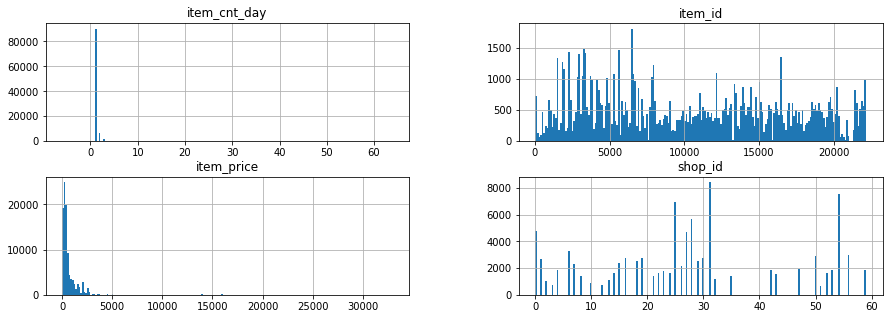

In [8]:
dfs1.hist(figsize=(15,5), bins=200);

In [9]:
#I will build clusters around shop_id to get better information by shop

total_shops = dfs1.groupby('shop_id')['item_cnt_day'].sum()
total_shops.sort_values(ascending=False).head()

shop_id
31    10173.0
54     9386.0
25     8215.0
28     7057.0
0      5578.0
Name: item_cnt_day, dtype: float64

In [10]:
#Let's use Big Data tips to analyze all Data : chunksize and concat

reader = pd.read_csv(salestrain,parse_dates=[0], nrows=100000, chunksize=20000)
reader

In [11]:
chunk = reader.get_chunk()
chunk.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [12]:
%%time
from datetime import datetime
reader = pd.read_csv(salestrain,parse_dates=[0], chunksize=500000)

partial_results = []
for nchunk, chunk in enumerate(reader):
    print('Starting with chunk %.2d at %s' % (nchunk, datetime.now()))
    dfs1 = chunk.drop('date_block_num', axis=1)
    total_shops = dfs1.groupby('shop_id')['item_cnt_day'].sum()
    partial_results.append(total_shops)
    
all_results = pd.concat(partial_results)

Starting with chunk 00 at 2019-02-03 17:06:34.546636
Starting with chunk 01 at 2019-02-03 17:07:10.888565
Starting with chunk 02 at 2019-02-03 17:07:47.701436
Starting with chunk 03 at 2019-02-03 17:08:24.127004
Starting with chunk 04 at 2019-02-03 17:09:00.537399
Starting with chunk 05 at 2019-02-03 17:09:32.602659
CPU times: user 3min 37s, sys: 136 ms, total: 3min 37s
Wall time: 3min 34s


In [13]:
totals = all_results.groupby('shop_id').sum()
ranking_shops = totals.sort_values(ascending=False)

In [30]:
rank_items = pd.DataFrame(ranking_shops)
rank_items.head(10)
#It is the ranking for the top 15 shops selling items, let's if it is the same for amount of sales

,item_cnt_day
shop_id,
31,310777.0
25,241920.0
54,185790.0
28,184557.0
42,144934.0
57,141107.0
27,136657.0
6,100489.0
58,81734.0


In [15]:
dfs1['Total_amount'] = dfs1['item_price']*dfs1['item_cnt_day']
dfs1.head()
#We have a new column to know what is the total amount of sales of each shop


,date,shop_id,item_id,item_price,item_cnt_day,Total_amount
2500000,2015-03-18,35,19430,899.0,1.0,899.0
2500001,2015-03-21,35,18972,198.0,1.0,198.0
2500002,2015-10-03,35,18923,399.0,1.0,399.0
2500003,2015-08-03,35,18923,399.0,1.0,399.0
2500004,2015-07-03,35,18923,399.0,1.0,399.0


In [16]:
%%time
from datetime import datetime
reader = pd.read_csv(salestrain,parse_dates=[0], chunksize=500000)

partial_amount_results = []
for nchunk, chunk in enumerate(reader):
    print('Starting with chunk %.2d at %s' % (nchunk, datetime.now()))
    dfs1 = chunk.drop('date_block_num', axis=1)
    dfs1['Total_amount'] = dfs1['item_price']*dfs1['item_cnt_day']
    total_amount_shops = dfs1.groupby('shop_id')['Total_amount'].sum()
    partial_amount_results.append(total_amount_shops)
    
all_amount_results = pd.concat(partial_amount_results)


Starting with chunk 00 at 2019-02-03 17:10:33.475605
Starting with chunk 01 at 2019-02-03 17:11:09.665360
Starting with chunk 02 at 2019-02-03 17:11:45.902193
Starting with chunk 03 at 2019-02-03 17:12:22.281511
Starting with chunk 04 at 2019-02-03 17:12:58.662608
Starting with chunk 05 at 2019-02-03 17:13:30.704224
CPU times: user 3min 36s, sys: 160 ms, total: 3min 37s
Wall time: 3min 33s


In [160]:
totals_amount = all_amount_results.groupby('shop_id').sum()
ranking_shops_amount = totals_amount.sort_values(ascending=False)

In [161]:
ranking_shops_amount_df = pd.DataFrame(ranking_shops_amount)
rank_amount = ranking_shops_amount_df['Total_amount'].astype('int64')
rank_amounts = pd.DataFrame(rank_amount)
rank_amounts.head(10)

,Total_amount
shop_id,
31,235217019
25,216480571
28,159746337
42,151917032
54,141939672
27,140632474
57,112999783
12,112205072
6,98067453


In [162]:
rank_amounts.shape

(60, 1)

In [163]:
Ranking_sales = pd.merge(rank_items, rank_amounts, on='shop_id', how='outer')

In [164]:
Ranking_sales.head(10)

,item_cnt_day,Total_amount
shop_id,,
31,310777.0,235217019
25,241920.0,216480571
54,185790.0,141939672
28,184557.0,159746337
42,144934.0,151917032
57,141107.0,112999783
27,136657.0,140632474
6,100489.0,98067453
58,81734.0,68737617


In [69]:
Ranking_sales.fillna(68737617, inplace=True)

In [70]:
Ranking_sales.iloc[[9], [1]] = 74189318  

In [72]:
Top_ten = Ranking_sales.head(10)
Top_ten

,item_cnt_day,Total_amount
shop_id,,
31,310777.0,235217019.0
25,241920.0,216480571.0
54,185790.0,141939672.0
28,184557.0,159746337.0
42,144934.0,151917032.0
57,141107.0,112999783.0
27,136657.0,140632474.0
6,100489.0,98067453.0
58,81734.0,68737617.0


In [169]:
Ranking_sales.sum().astype('int64')

item_cnt_day       3648206
Total_amount    3398926317
dtype: int64

In [168]:
def items (item):
    return item / 3648206
        
items(310777.0)

0.0851862531885535

In [167]:
def amounts (amount):
    return amount / 3398926317

amounts(98067453.0)

0.028852479828558753

In [170]:
Top_ten['Perc_items'] = Top_ten['item_cnt_day'].apply(items)
Top_ten['Perc_amounts'] = Top_ten['Total_amount'].apply(amounts)
Top_ten

/home/vant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/vant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,item_cnt_day,Total_amount,Perc_items,Perc_amounts
shop_id,,,,
31,310777.0,235217019.0,0.085186,0.069203
25,241920.0,216480571.0,0.066312,0.063691
54,185790.0,141939672.0,0.050926,0.041760
28,184557.0,159746337.0,0.050588,0.046999
42,144934.0,151917032.0,0.039727,0.044696
57,141107.0,112999783.0,0.038678,0.033246
27,136657.0,140632474.0,0.037459,0.041376
6,100489.0,98067453.0,0.027545,0.028852
58,81734.0,68737617.0,0.022404,0.020223


In [171]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import plotly

plotly.offline.init_notebook_mode(connected=True)

fig = {
  "data": [
    {
      "values": [8.5, 6.6, 5.0, 5.0, 3.9, 3.8, 3.7, 2.7, 2.2, 2.1, 56.5],
      "labels": [
        "31",
        "25",
        "54",
        "28",
        "42",
        "57",
        "27",
        "6",
        "58",
        "46",
        "Rest",
      ],
      "domain": {"x": [0, .48]},
      "name": "Items Rank",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },
    {
      "values": [6.9, 6.3, 4.1, 4.6, 4.4, 3.3, 4.1, 2.8, 2.0, 2.1, 59.4],
      "labels": [
        "31",
        "25",
        "54",
        "28",
        "42",
        "57",
        "27",
        "6",
        "58",
        "46",
        "Rest",
      ],
      "domain": {"x": [.52, 1]},
      "name": "Total Amount",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Top Ten Ranking",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Items",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Amount",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}


offline.iplot(fig, filename='pie1')


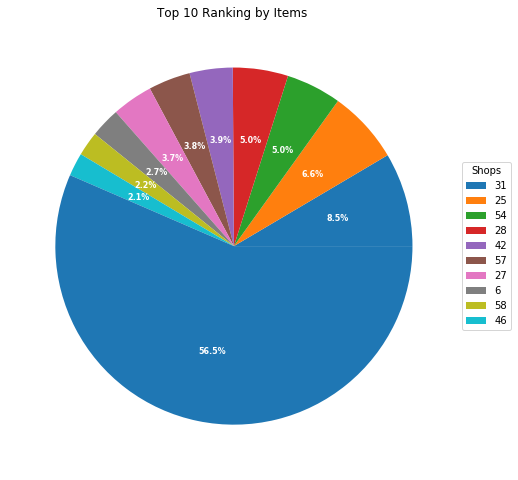

In [179]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 30), subplot_kw=dict(aspect="equal"))

data = [31,25,54,28,42,57,27,6,58,46]
pcts = [8.5, 6.6, 5.0, 5.0, 3.9, 3.8, 3.7, 2.7, 2.2, 2.1, 56.5]

def func(pct, pcts):
    absolute = int(np.sum(pcts))
    return "{:.1f}%".format(pct,absolute)


wedges, texts, autotexts = ax.pie(pcts, autopct=lambda pct: func(pct, data) , textprops=dict(color="w"))

ax.legend(wedges, data,
          title="Shops",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Top 10 Ranking by Items ")

plt.show()


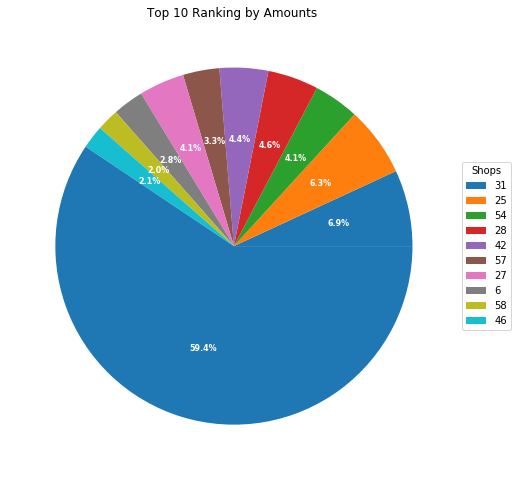

In [180]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 30), subplot_kw=dict(aspect="equal"))

data = [31,25,54,28,42,57,27,6,58,46]
pcts1 = [6.9, 6.3, 4.1, 4.6, 4.4, 3.3, 4.1, 2.8, 2.0, 2.1, 59.4]

def func(pct, pcts1):
    absolute = int(np.sum(pcts1))
    return "{:.1f}%".format(pct,absolute)


wedges, texts, autotexts = ax.pie(pcts1, autopct=lambda pct: func(pct, data) , textprops=dict(color="w"))

ax.legend(wedges, data,
          title="Shops",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Top 10 Ranking by Amounts ")

plt.show()
